In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Alguns parâmetros para leitura do dataset
im_shape = (299,299)

TRAINING_DIR = '/content/drive/MyDrive/AI/TransferLearning/ds_frutas_am/train'
TEST_DIR = '/content/drive/MyDrive/AI/TransferLearning/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

In [ ]:
# With augmentation
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [ ]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


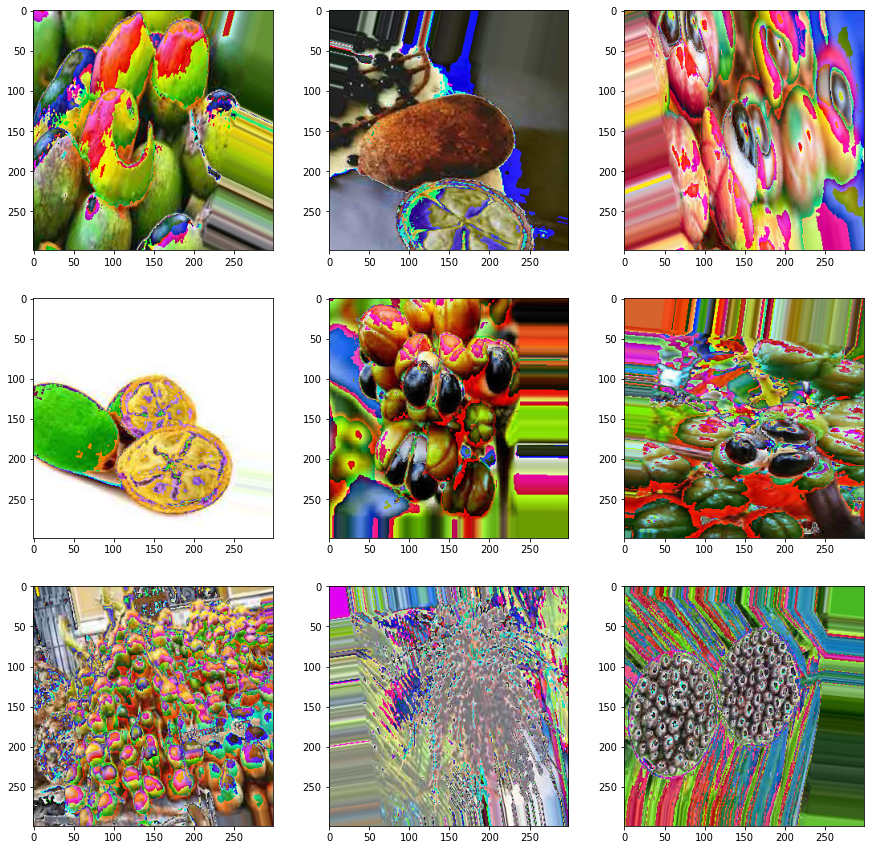

In [ ]:
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

#Transfer Learning from a Deep Model

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
epochs = 80

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
4/4 [==============================] - ETA: 0s - loss: 9.5674 - accuracy: 0.1429 
Epoch 1: val_loss improved from inf to 2.71444, saving model to model.h5
4/4 [==============================] - 63s 15s/step - loss: 9.5674 - accuracy: 0.1429 - val_loss: 2.7144 - val_accuracy: 0.4375
Epoch 2/80
4/4 [==============================] - ETA: 0s - loss: 4.0310 - accuracy: 0.2969
Epoch 2: val_loss improved from 2.71444 to 1.92134, saving model to model.h5
4/4 [==============================] - 40s 11s/step - loss: 4.0310 - accuracy: 0.2969 - val_loss: 1.9213 - val_accuracy: 0.6250
Epoch 3/80
4/4 [==============================] - ETA: 0s - loss: 2.1447 - accuracy: 0.5714
Epoch 3: val_loss improved from 1.92134 to 1.64092, saving model to model.h5
4/4 [==============================] - 37s 11s/step - loss: 2.1447 - accuracy: 0.5714 - val_loss: 1.6409 - val_accuracy: 0.6875
Epoch 4/80
4/4 [==============================] - ETA: 0s - loss: 1.6365 - accuracy: 0.6250
Epoch 4: val_loss im

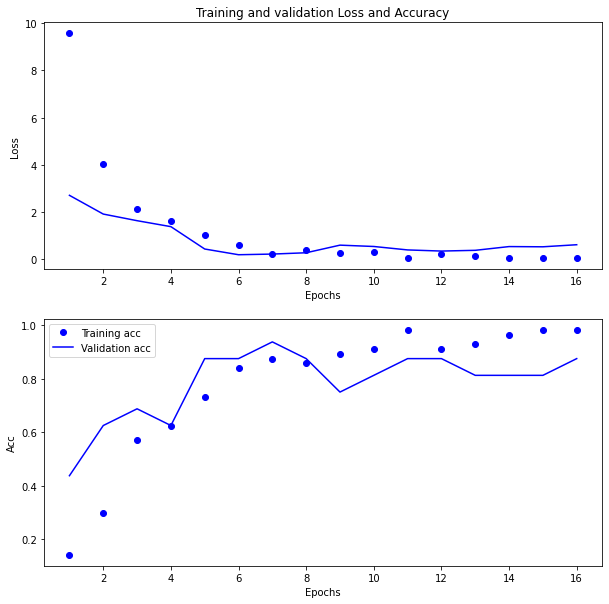

In [ ]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()